In [2]:
# Run onluy the first time!
# from pyunpack import Archive
# Archive('Images.zip').extractall('Assignment4_Images')
!pip install torchtext==0.6

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 1.1MB 9.7MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from PIL import Image
from torchtext.vocab import GloVe
from torchtext.data import Field
from torchtext.data.metrics import bleu_score
import torchtext
from torchtext.data import get_tokenizer
import pdb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, image_list, captions):
        
        self.folder = folder
        self.captions = captions
        self.size = 5*len(image_list)
        self.image_list = []
        for image in image_list:
            all_images = [image + '#' + str(i) for i in range(5)]
            self.image_list.extend(all_images)
        
    def __getitem__(self, idx):     
        
        image_name = self.image_list[idx]
        caption = self.captions.loc[image_name, 'Caption']
        img = Image.open(self.folder + image_name[:-2]).resize((227, 227))
        trans = transforms.ToTensor()
        return trans(img), caption
      
    def __len__(self):
        
        return self.size

In [4]:
def train_test_loader(directory, image_list, captions, train_fraction=0.8, num_workers=0, batch_size=32):

    dataset = DatasetClass(directory, image_list, captions)
    
    N = dataset.size
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [7]:
with open('/content/drive/My Drive/captions.txt') as f:
    captions = pd.read_csv(StringIO(f.read()), sep='\t', header=None, names=['Image', 'Caption']).set_index('Image', drop=True)
    
with open('/content/drive/My Drive/image_names.txt') as f:
    names = list(map(lambda x: x.rstrip(), f.readlines()))

# with open('captions.txt') as f:
#     captions = pd.read_csv(StringIO(f.read()), sep='\t', header=None, names=['Image', 'Caption']).set_index('Image', drop=True)
    
# with open('image_names.txt') as f:
#     names = list(map(lambda x: x.rstrip(), f.readlines()))

In [14]:
trainloader, testloader, train_size, test_size = train_test_loader(directory='/content/drive/My Drive/Assignment4_Data/Images/', image_list=names, captions=captions)

#### GloVe Representation

Available GloVe Representations: 

1. glove.42B.300d 
2. glove.840B.300d 
3. glove.twitter.27B.25d 
4. glove.twitter.27B.50d 
5. glove.twitter.27B.100d 
6. glove.twitter.27B.200d 
7. glove.6B.50d 
8. glove.6B.100d 
9. glove.6B.200d 
10. glove.6B.300d

In [ ]:
embedding_glove = GloVe(name='6B', dim=100)

In [ ]:
text_field = Field(tokenize='basic_english', lower=True, eos_token='eos', init_token='sos')
preprocessed_text = captions['Caption'].apply(lambda x: text_field.preprocess(x))

In [ ]:
text_field.build_vocab(preprocessed_text, vectors=embedding_glove)
embedding_trained = text_field.vocab.vectors[2:, :]
# embedding_trained = nn.Embedding.from_pretrained(text_field.vocab.vectors[2:, :])

In [ ]:
vocab_tokens = np.array(text_field.vocab.itos)[2:]

In [27]:
class NetVLAD(nn.Module):
    
    def __init__(self, k):
        super(NetVLAD, self).__init__()
        
        # CNN
        self.c1 = nn.Conv2d(3, 96, 11, stride=4)
        self.mp1 = nn.MaxPool2d(3, stride=2)
        self.c2 = nn.Conv2d(96, 256, 5)
        self.mp2 = nn.MaxPool2d(3, stride=2)
        self.c3 = nn.Conv2d(256, 384, 3)
        self.c4 = nn.Conv2d(384, 384, 3)
        self.c5 = nn.Conv2d(384, 256, 3, stride=3)

        # NetVLAD
        self.K = k
        self.nv_conv = nn.Conv2d(256, k, 1)
        self.nv_soft_ass = nn.Softmax2d()

        # NetVLAD Parameter
        self.c = nn.Parameter(torch.Tensor(self.K, 256))
        
        # Flatten to get h
        self.flat = nn.Flatten(1, -1)

    def forward(self, x):
        
        # CNN
        x = self.mp1(F.relu(self.c1(x)))
        x = self.mp2(F.relu(self.c2(x)))
        x = F.relu(self.c5(F.relu(self.c4(F.relu(self.c3(x))))))

        self.z_pre = x.flatten(2, 3)

        # NetVLAD Step 1
        a = self.nv_soft_ass(self.nv_conv(x))

        # NetVLAD Step 2
        for k in range(self.K):
            a_k = a[:, k, :, :]
            c_k = self.c[k, :]
            temp = (x - c_k.reshape(1, -1, 1, 1))*a_k.unsqueeze(1)
            z_k = torch.sum(temp, axis=(2, 3))
            if k==0:
                Z = z_k.unsqueeze(1)
            else:
                Z = torch.cat((Z, z_k.unsqueeze(1)), 1)
        
        # Flatten
        Z = self.flat(Z)

        return Z

In [28]:
cnn_model = NetVLAD(1).to(device)

In [29]:
for data in trainloader:
  X = data[0].to(device)

  with torch.no_grad():
    _ = cnn_model(X)
    Z_pre = cnn_model.z_pre
  break

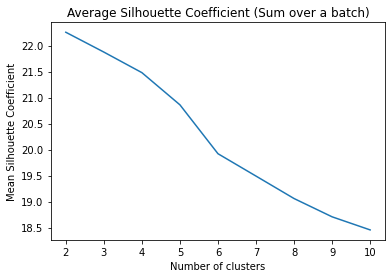

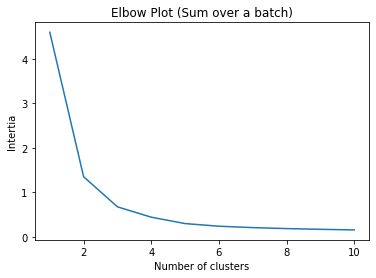

In [59]:
sh_full = np.zeros(9)
inertia_full = np.zeros(10)

for i in range(Z_pre.shape[0]):
  inertia = []
  sh_mean = []
  for n_clusters in range(1, 11):
    X = Z_pre[i, :, :].cpu().numpy()
    model = KMeans(n_clusters).fit(X)
    inertia.append(model.inertia_)

    if n_clusters != 1:
      cluster_labels = KMeans(n_clusters).fit_predict(X)
      sh_mean.append(silhouette_score(X, cluster_labels))

  sh_full += np.array(sh_mean)
  inertia_full += np.array(inertia)

plt.plot(range(2, 11), sh_full)
plt.title('Average Silhouette Coefficient (Sum over a batch)')
plt.xlabel('Number of clusters')
plt.ylabel('Mean Silhouette Coefficient')
plt.show()
plt.plot(range(1, 11), inertia_full)
plt.title('Elbow Plot (Sum over a batch)')
plt.xlabel('Number of clusters')
plt.ylabel('Intertia')
plt.show()

In [ ]:
class RNN(nn.Module):

    def __init__(self, embed_size, hidden_size, output_size, embedding_pre_trained):
        
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Pre-trained Word Embedding of all the words is used
        self.embedding = nn.Embedding.from_pretrained(embedding_pre_trained)
        
        # Input to the RNN is word embeddings of a word
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size) 
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)  
        
    def forward(self, input_vec, hidden_vec):
        '''
        Parameters:
        ------------
        input_vec  - tensor of index of word/token. Example: torch.LongTensor([[0]]) for sos_token
        hidden_vec - train_image or output from previous RNN cell
        '''
        try:

            embedded_input_vec = self.embedding(input_vec)
            output_vec, hidden_vec = self.rnn(embedded_input_vec, hidden_vec)
            output_vec = self.softmax(self.out(output_vec[0]))
        except:
            pdb.set_trace()

        return output_vec, hidden_vec      


In [ ]:
# class LSTM(nn.Module):

#     def __init__(self, embed_size, hidden_size, output_size, embedding_pre_trained):
        
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
        
#         # Pre-trained Word Embedding of all the words is used
#         self.embedding = nn.Embedding.from_pretrained(embedding_pre_trained)
        
#         # Input to the RNN is word embeddings of a word
#         self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size) 
#         self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)  
        
#     def forward(self, input_vec, hidden_vec):
#         '''
#         Parameters:
#         ------------
#         input_vec  - tensor of index of word/token. Example: torch.LongTensor([[0]]) for sos_token
#         hidden_vec - train_image or output from previous RNN cell
#         '''
#         embedded_input_vec = self.embedding(input_vec)
#         output_vec, hidden_vec = self.lstm(embedded_input_vec, hidden_vec)
#         output_vec = self.softmax(self.out(output_vec[0]))
#         return output_vec, hidden_vec      
    
    

In [ ]:
def train_one_image(train_image, image_caption, encoder_obj, decoder_obj, encoder_optim, decoder_optim, loss_func, vocab_tokens):
    '''
    Parameters:
    -----------
    train_image     - Images stored in batches using DataLoader
    image_caption   - Caption of the image (in the same word embedding representation used in )

    
    '''
    # Start of sentence and End of Sentence token
    eos_token = np.argwhere(vocab_tokens=='eos').item()
    sos_token = np.argwhere(vocab_tokens=='sos').item()
    
    # Length of the image caption
    caption_length = len(image_caption)
    
    # Setting gradients from previous backpropagation to zero
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    
    # TO BE CHECKED!!!!!!!!!!!!!!
    encoder_output = encoder_obj(train_image).view(1, 1, -1) 
    
    decoder_input = torch.tensor([[sos_token]], device=device)  ## This is converted into an embedding withing the decoder class
    decoder_hidden = encoder_output
    decoder_hidden_size = decoder_hidden.shape[-1]

    try:
    
        loss = 0
        for i in range(caption_length):
            decoder_output, decoder_hidden = decoder_obj(decoder_input, decoder_hidden) 
            max_val, max_ind = decoder_output.topk(1)  # Choosing the word with maximum probability 
            decoder_input = max_ind  #.squeeze().detach()                     
            loss += loss_func(decoder_output, torch.tensor([np.argwhere(vocab_tokens == image_caption[i]).item()]).to(device))
            if decoder_input.item() == eos_token:
                break
#             print(loss)
        loss.backward()
        encoder_optim.step()
        decoder_optim.step()
    except:
        pdb.set_trace()

    return loss.item()/caption_length
    

In [ ]:
def train(lr, trainloader_images, train_images_size, encoder_obj, decoder_obj, preprocessed_text, captions, vocab_tokens):
    
    loss_func = nn.NLLLoss()

    tokenizer = get_tokenizer("basic_english")
    
    encoder_optim = optim.SGD(encoder_obj.parameters(), lr=lr)
    decoder_optim = optim.SGD(decoder_obj.parameters(), lr=lr)
    
    old_loss = np.inf
    epoch = 0
    losses = []
    while True:
        new_loss = 0
        epoch += 1
        batch = 0 
        for data in trainloader_images:
            batch += 1
            images, captions = data[0].to(device), data[1]
            bs = images.shape[0]

            for i in range(bs):
                train_image = images[i].view(1, images.shape[1], images.shape[2], images.shape[3])
                image_caption = tokenizer(captions[i])
                image_caption.append('eos')
                new_loss += train_one_image(train_image, image_caption, encoder_obj, decoder_obj, encoder_optim, decoder_optim, loss_func, vocab_tokens)
            
            print('Batch {0}'.format(batch))
            
        new_loss = new_loss/train_images_size
        
        print('Epoch {0}: Loss = {1}, Rel loss = {2}'.format(epoch, new_loss, abs(new_loss-old_loss)/new_loss))
        losses.append(new_loss)

        if abs(new_loss-old_loss)/new_loss < 1e-5:
            print('Converged')
            return losses

        old_loss = new_loss

In [ ]:
k = 1
decoder_hidden_size = 256 ###(fix laterrrrrrrrrrrr)

encoder_obj = NetVLAD(k).to(device)

embed_size = embedding_trained.shape[1]
decoder_output_size = embedding_trained.shape[0]
decoder_obj = RNN(embed_size, decoder_hidden_size, decoder_output_size, embedding_trained).to(device)

losses = train(0.01, trainloader, train_size, encoder_obj, decoder_obj, preprocessed_text, captions, vocab_tokens)

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 11

Batch 337
Batch 338
Batch 339
Batch 340
Batch 341
Batch 342
Batch 343
Batch 344
Batch 345
Batch 346
Batch 347
Batch 348
Batch 349
Batch 350
Batch 351
Batch 352
Batch 353
Batch 354
Batch 355
Batch 356
Batch 357
Batch 358
Batch 359
Batch 360
Batch 361
Batch 362
Batch 363
Batch 364
Batch 365
Batch 366
Batch 367
Batch 368
Batch 369
Batch 370
Batch 371
Batch 372
Batch 373
Batch 374
Batch 375
Batch 376
Batch 377
Batch 378
Batch 379
Batch 380
Batch 381
Batch 382
Batch 383
Batch 384
Batch 385
Batch 386
Batch 387
Batch 388
Batch 389
Batch 390
Batch 391
Batch 392
Batch 393
Batch 394
Batch 395
Batch 396
Batch 397
Batch 398
Batch 399
Batch 400
Batch 401
Batch 402
Batch 403
Batch 404
Batch 405
Batch 406
Batch 407
Batch 408
Batch 409
Batch 410
Batch 411
Batch 412
Batch 413
Batch 414
Batch 415
Batch 416
Batch 417
Batch 418
Batch 419
Batch 420
Batch 421
Batch 422
Batch 423
Batch 424
Batch 425
Batch 426
Batch 427
Batch 428
Batch 429
Batch 430
Batch 431
Batch 432
Batch 433
Batch 434
Batch 435
Batch 436


BdbQuit: 

In [ ]:
def evaluate(encoder_obj, decoder_obj, image, image_caption, vocab_tokens):
    with torch.no_grad():

        # Start of sentence and End of Sentence token
        sos_token = np.argwhere(vocab_tokens=='sos').item()
        eos_token = np.argwhere(vocab_tokens=='eos').item()

        # Length of the image caption
        caption_length = image_caption.size(0)


        # TO BE CHECKED!!!!!!!!!!!!!!
        encoder_output = encoder_obj(image).view(1, 1, -1)  
        decoder_hidden_size = encoder_output.shape[-1]
        
        decoder_input = torch.tensor([[sos_token]], device=device)
        decoder_hidden = encoder_output

        output_caption = []
        for i in range(caption_length):
            decoder_output, decoder_hidden = decoder_obj(decoder_input, decoder_hidden) 
            max_val, max_ind = decoder_output.topk(1)  # Choosing the word with maximum probability 
            decoder_input = max_ind 
            loss += loss_func(decoder_output, image_caption[i])
            if decoder_input.item() == eos_token:
                output_caption.append('eos')
                break
            else:
                output_caption.append(vocab_tokens[decoder_input.item()])

        return bleu_score(image_caption, output_caption)

### Question 1

### Question 2

In [ ]:
k = 1
decoder_hidden_size =50

encoder_obj = NetVLAD(k).to(device)

embed_size = embedding_trained.weight.shape[1]
decoder_output_size = embedding_trained.weight.shape[0]
decoder_obj = LSTM(embed_size, decoder_hidden_size, decoder_output_size, embedding_trained).to(device)

train(lr=0.01, trainloader, encoder_obj, decoder_obj)